In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as mtick
import numpy as np
import os
from glob import glob
from random import shuffle, seed
import shutil
import cv2
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.nn import BCELoss
from tqdm.notebook import tqdm
from torchinfo import summary
import torchvision
from torchvision import transforms, models
from torchvision.models import VGG16_Weights

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#Reproducability
seed(42)
torch.manual_seed(42)

In [4]:
IMG_SIZE = 224

#### CAT: 0; DOG: 1

# Inspect the data

In [5]:
train_dir = 'train'
test_dir = 'test1'

In [6]:
os.listdir(train_dir)[:5]

['dog.4305.jpg',
 'dog.2640.jpg',
 'dog.3795.jpg',
 'dog.4766.jpg',
 'cat.2785.jpg']

In [7]:
os.listdir(test_dir)[:3]

['7813.jpg', '6116.jpg', '3885.jpg']

Split the training data into train & val set

## See how balanced the data is

In [8]:
num_dogs = len(glob(train_dir + '/dog*'))
num_cats = len(glob(train_dir + '/cat*'))
print(f'Number of Cats: {num_cats};\nNumber of Dogs: {num_dogs}')

Number of Cats: 12500;
Number of Dogs: 12500


## Split the data

In [9]:
#return two lists with train & val files (70-30-split)
def split_data(folder):
    train_files = []
    valid_files = []
    
    cats = glob(train_dir + '/cat*')
    dogs = glob(train_dir + '/dog*')
    
    shuffle(cats)
    shuffle(dogs)
    
    #index on which to split the lists
    cat_index = int(0.7 * len(cats))
    dog_index = int(0.7 * len(dogs))
    
    train_files.extend(cats[:cat_index])
    valid_files.extend(cats[cat_index:])
    train_files.extend(dogs[:dog_index])
    valid_files.extend(dogs[dog_index:])
    
    print(f'Train Files: {len(train_files)};\nValid Files: {len(valid_files)}')
    
    return train_files, valid_files

In [10]:
train_files, valid_files = split_data(folder=train_dir)

Train Files: 17500;
Valid Files: 7500


In [11]:
def create_train_val_folder(folder, train, valid):
    train_folder = 'Training_Data'
    valid_folder = 'Valid_Data'
    
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
        for file in train:
            shutil.copy2(file, train_folder)
            
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        for file in valid:
            shutil.copy2(file, valid_folder)
    
    print(f'Files in Training_Folder: {len(os.listdir(train_folder))}')
    print(f'Files in Valid_Folder: {len(os.listdir(valid_folder))}')

In [12]:
create_train_val_folder(folder=train_dir, train=train_files, valid=valid_files)

Files in Training_Folder: 17500
Files in Valid_Folder: 7500


# Build a Dataset & Dataloader to get batches

In [13]:
class Cats_Dogs(Dataset):
    
    def __init__(self, folder):
        
        self.files = glob(folder + '/*')  # all files
        shuffle(self.files)
        get_target = lambda x: 1 if 'dog' in x else 0  # function to get correct target
        self.targets = [get_target(x) for x in self.files]  # create targets
        self.n_samples = len(self.files)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        X = self.files[index]
        y = self.targets[index]
        y = torch.tensor(y).float()
        X = cv2.imread(X)[:, :, ::-1]  # BGR --> RGB
        X = cv2.resize(X, (IMG_SIZE, IMG_SIZE))
        X = torch.tensor(X).float() / 255  # scale and make float
        X = X.permute(2, 0, 1)  # channels in first dim

        return X.to(device), y.to(device)

In [14]:
train_dataset = Cats_Dogs(folder='Training_Data')
valid_dataset = Cats_Dogs(folder='Valid_Data')

In [15]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=True)

# Build a CNN

In [16]:
class Cat_Dog_Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), padding='valid')  # first layer: less filter but bigger kernel
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, (3, 3), padding='valid')
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, (3, 3), padding='valid')
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(256, 512, (3, 3), padding='valid')
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(512, 512, (3, 3), padding='valid')
            
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
            
        self.fc1 = nn.Linear(512, 32)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 1)
        self.out = nn.Sigmoid()
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        
        x = self.avgpool(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return x

In [17]:
model_1 = Cat_Dog_Net().to(device)

In [18]:
summary(model_1, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Cat_Dog_Net                              [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 220, 220]         4,864
├─MaxPool2d: 1-2                         [1, 64, 110, 110]         --
├─Conv2d: 1-3                            [1, 128, 108, 108]        73,856
├─MaxPool2d: 1-4                         [1, 128, 54, 54]          --
├─Conv2d: 1-5                            [1, 256, 52, 52]          295,168
├─MaxPool2d: 1-6                         [1, 256, 26, 26]          --
├─Conv2d: 1-7                            [1, 512, 24, 24]          1,180,160
├─MaxPool2d: 1-8                         [1, 512, 12, 12]          --
├─Conv2d: 1-9                            [1, 512, 10, 10]          2,359,808
├─AdaptiveAvgPool2d: 1-10                [1, 512, 1, 1]            --
├─Flatten: 1-11                          [1, 512]                  --
├─Linear: 1-12                           [1, 32]           

In [19]:
loss_bc = BCELoss()

In [20]:
optim = Adam(model_1.parameters(), lr=1e-4)

# Write functions to train a batch and calculate the loss/accuracy

In [21]:
'''Function for predicting a batch, calculating the loss,
   calculate the gradients & adjust them'''
def train_batch(model, optimizer, loss, X, y):
    model.train()
    
    pred = model(X) 
    
    pred = pred.squeeze()
    
    batch_loss = loss(pred, y)
    
    batch_loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    return batch_loss.item()

In [22]:
'''Function for calculating the accuracy without adjusting the weights'''
@torch.no_grad()
def calculate_accuracy(model, X, y):
    model.eval()
    
    pred = model(X)
    
    pred = pred.squeeze()  # dims must match for pred & y
    
    correct = (pred > 0.5)  == y  # True if prediction > 0.5 == 1 or < 0.5 == 0
    
    accuracy = correct.sum() / correct.__len__()
    
    accuracy = accuracy.tolist()
    
    return np.array(accuracy)

In [23]:
'''Function for calculating validation loss without adjusting the weights'''
@torch.no_grad()
def calculate_val_loss(model, loss, X, y):
    model.eval()
    
    pred = model(X)
    
    pred = pred.squeeze()
    
    batch_loss = loss(pred, y)
    
    return batch_loss.item()

# Train the model and plot the train/val - loss/accuracy

In [24]:
NUM_EPOCHS = 5

In [25]:
'''Train the model for some epochs. In each epoch feed in all the batches (train and valid).
   Calculate the loss and accuracy for each batch and add them up after each epoch.
   Save the numbers after each epoch to plot them.'''

num_epochs = 5

train_epoch_losses, valid_epoch_losses = [], []
train_epoch_accuracies, valid_epoch_accuracies = [], []
    
for epoch in tqdm(range(num_epochs)):

    train_epoch_loss, valid_epoch_loss = [], []
    train_epoch_accuracy, valid_epoch_accuracy = [], []

    #training & get train loss
    for index, (X, y) in tqdm(enumerate(train_dataloader)):
        batch_loss = train_batch(model_1, optim, loss_bc, X, y)
        train_epoch_loss.append(batch_loss)
    train_epoch_loss_mean = np.array(train_epoch_loss).mean()
    train_epoch_losses.append(train_epoch_loss_mean)

    #get train accuracy
    for index, (X, y) in tqdm(enumerate(train_dataloader)):
        train_accuracy = calculate_accuracy(model_1, X, y)
        train_epoch_accuracy.append(train_accuracy)
    train_epoch_accuracy_mean = np.array(train_epoch_accuracy).mean()
    train_epoch_accuracies.append(train_epoch_accuracy_mean)

    #get valid loss and accuracy
    for index, (X, y) in tqdm(enumerate(valid_dataloader)):
        batch_loss = calculate_val_loss(model_1, loss_bc, X, y)
        valid_epoch_loss.append(batch_loss)

        batch_accuracy = calculate_accuracy(model_1, X, y)
        valid_epoch_accuracy.append(batch_accuracy)

    valid_epoch_loss_mean = np.array(valid_epoch_loss).mean()
    valid_epoch_accuracy_mean = np.array(valid_epoch_accuracy).mean()

    valid_epoch_losses.append(valid_epoch_loss_mean)
    valid_epoch_accuracies.append(valid_epoch_accuracy_mean)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

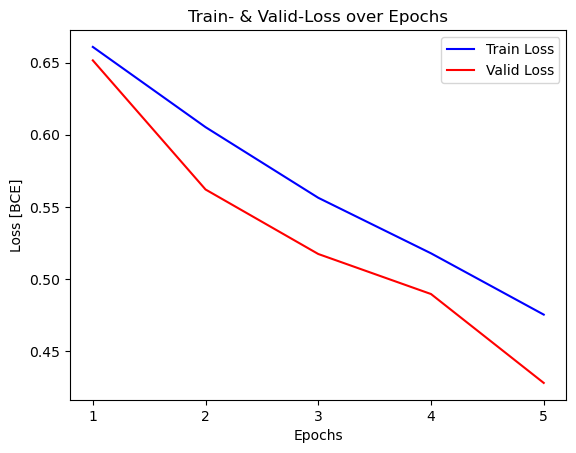

In [27]:
Epochs_List = list(range(1, 6))  # 5 epochs
plt.plot(Epochs_List, train_epoch_losses, color='blue', label='Train Loss')
plt.plot(Epochs_List, valid_epoch_losses, color='red', label='Valid Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss [BCE]')
plt.title('Train- & Valid-Loss over Epochs')
plt.legend()
plt.show()

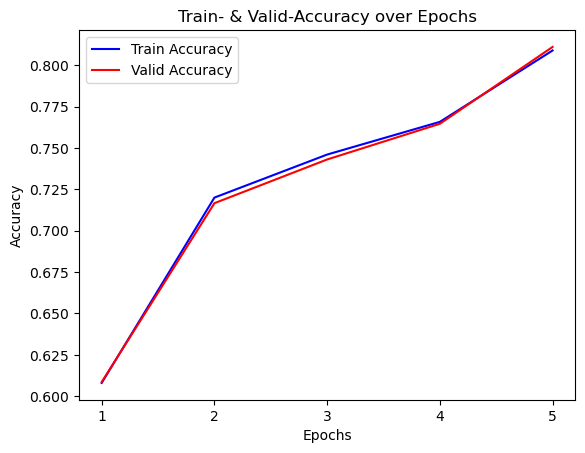

In [28]:
Epochs_List = list(range(1, num_epochs + 1))
plt.plot(Epochs_List, train_epoch_accuracies, color='blue', label='Train Accuracy')
plt.plot(Epochs_List, valid_epoch_accuracies, color='red', label='Valid Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train- & Valid-Accuracy over Epochs')
plt.legend()
plt.show()

Validation loss is still decreasing rapidly & validation accuracy going up, so longer training would be needed

# Now lets use a pretrained net that already learned multiple features 

For a preptrained model its good practice to normalize (mean and std for all RGB-channels) the inputs based on the original datasets statistics (for ImageNet its mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

## Build a new Dataset & DataLoader

In [29]:
class Cats_Dogs_VGG(Dataset):
    
    def __init__(self, folder):
        
        self.files = glob(folder + '/*')  # all files
        shuffle(self.files)
        get_target = lambda x: 1 if 'dog' in x else 0  # function to get correct target
        self.targets = [get_target(x) for x in self.files]  # create targets
        self.n_samples = len(self.files)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        X = self.files[index]
        y = self.targets[index]
        y = torch.tensor(y).float()
        X = cv2.imread(X)[:, :, ::-1]  # BGR --> RGB
        X = cv2.resize(X, (IMG_SIZE, IMG_SIZE))
        X = torch.tensor(X).float() / 255  # scale and make float
        X = X.permute(2, 0, 1)  # channels in first dim
        X = self.normalize(X)
        
        return X.to(device), y.to(device)

In [30]:
train_dataset_VGG = Cats_Dogs_VGG(folder='Training_Data')
valid_dataset_VGG = Cats_Dogs_VGG(folder='Valid_Data')

In [31]:
train_dataloader_VGG = DataLoader(dataset=train_dataset_VGG, batch_size=32, shuffle=True)
valid_dataloader_VGG = DataLoader(dataset=valid_dataset_VGG, batch_size=32, shuffle=True)

Get the VGG16 model & freeze the weights which are allready trained

In [32]:
model_2_VGG = models.vgg16(weights=VGG16_Weights.DEFAULT)

In [33]:
for param in model_2_VGG.parameters():
    param.requires_grad = False

In [34]:
summary(model_2_VGG, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

All weights frozen, so no parameter is trainable

The last two modules (AdaptiveAvgPool2d & Sequential) can be replaced

In [35]:
model_2_VGG.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

In [36]:
class model_2_VGG_Out(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        
        self.fc_1 = nn.Linear(512, 128)
        self.bn_1 = nn.BatchNorm1d(128)
        self.act_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        
        self.fc_2 = nn.Linear(128, 32)
        self.bn_2 = nn.BatchNorm1d(32)
        self.act_2 = nn.ReLU()
        self.drop_2 = nn.Dropout(0.2)
        
        self.fc_3 = nn.Linear(32, 1)
        self.out = nn.Sigmoid()
        
    def forward(self, x):
        x = self.flat(x)
        
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.drop_1(x)
        
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.drop_2(x)
        
        x = self.fc_3(x)
        x = self.out(x)
        
        return x

In [37]:
model_2_VGG_OUT = model_2_VGG_Out()

In [38]:
model_2_VGG.classifier = model_2_VGG_OUT

In [39]:
summary(model_2_VGG, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

Now 70,145 trainable new parameters (weights no frozen)

In [40]:
optimizer_2_VGG = Adam(model_2_VGG.parameters(), lr=1e-4)

In [41]:
loss_2_VGG = nn.BCELoss()

In [42]:
model_2_VGG.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Train the second model with the pretrained VGG architecture for 5 epochs and see differnece

In [48]:
num_epochs = 5

train_losses_VGG, valid_losses_VGG = [], []
train_accuracies_VGG, valid_accuracies_VGG = [], []
    
for epoch in tqdm(range(num_epochs)):

    train_loss_VGG, valid_loss_VGG = [], []
    train_accuracy_VGG, valid_accuracy_VGG = [], []

    #training & get train loss
    for index, (X, y) in tqdm(enumerate(train_dataloader_VGG)):
        batch_loss = train_batch(model_2_VGG, optimizer_2_VGG, loss_2_VGG, X, y)
        train_loss_VGG.append(batch_loss)
    train_loss_VGG_mean = np.array(train_loss_VGG).mean()
    train_losses_VGG.append(train_loss_VGG_mean)

    #get train accuracy
    for index, (X, y) in tqdm(enumerate(train_dataloader_VGG)):
        train_accuracy = calculate_accuracy(model_2_VGG, X, y)
        train_accuracy_VGG.append(train_accuracy)
    train_accuracy_VGG_mean = np.array(train_accuracy_VGG).mean()
    train_accuracies_VGG.append(train_accuracy_VGG_mean)

    #get valid loss and accuracy
    for index, (X, y) in tqdm(enumerate(valid_dataloader_VGG)):
        batch_loss = calculate_val_loss(model_2_VGG, loss_2_VGG, X, y)
        valid_loss_VGG.append(batch_loss)

        batch_accuracy = calculate_accuracy(model_2_VGG, X, y)
        valid_accuracy_VGG.append(batch_accuracy)

    valid_loss_VGG_mean = np.array(valid_loss_VGG).mean()
    valid_accuracy_VGG_mean = np.array(valid_accuracy_VGG).mean()

    valid_losses_VGG.append(valid_loss_VGG_mean)
    valid_accuracies_VGG.append(valid_accuracy_VGG_mean)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

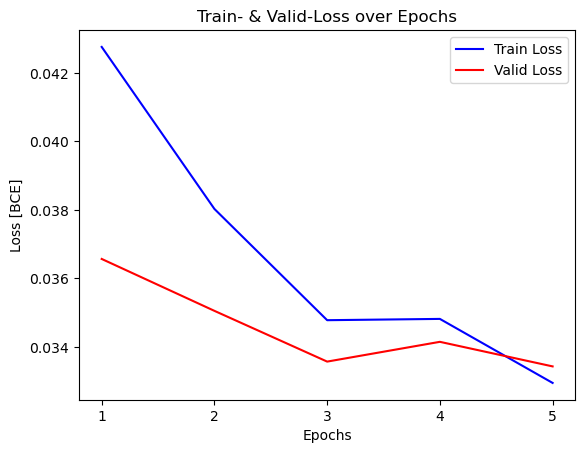

In [49]:
Epochs_List = list(range(1, 6))  # 5 epochs
plt.plot(Epochs_List, train_losses_VGG, color='blue', label='Train Loss')
plt.plot(Epochs_List, valid_losses_VGG, color='red', label='Valid Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss [BCE]')
plt.title('Train- & Valid-Loss over Epochs')
plt.legend()
plt.show()

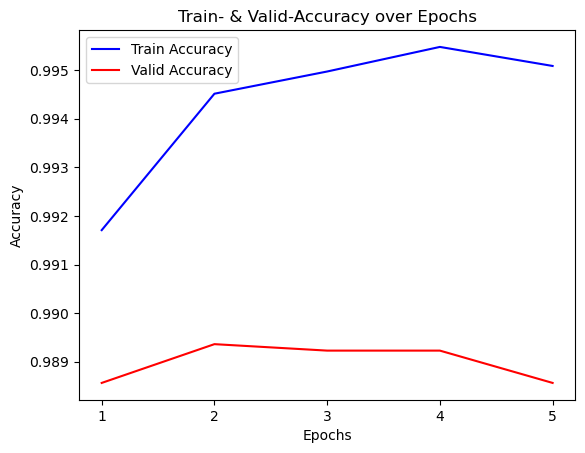

In [50]:
Epochs_List = list(range(1, num_epochs + 1))
plt.plot(Epochs_List, train_accuracies_VGG, color='blue', label='Train Accuracy')
plt.plot(Epochs_List, valid_accuracies_VGG, color='red', label='Valid Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train- & Valid-Accuracy over Epochs')
plt.legend()
plt.show()

The accuracy was around 98.5% at the second epoch, which is a lot better

Possible next steps: Increase Regularization, Lower/reduceonplateau LR, data augmentation, modelcheckpoint (save weights at best value)